### Reconocimiento de dígitos manuscritos con MLP

In [1]:
# Eugenio Sánchez | Noviembre 2023
# IIT | Comillas - ICAI

In [2]:
# importa paquetes
import util_mlp_cnn_ESU23
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import os

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# define hardware
device = torch.device('cpu')

#### 1. Preparamos los datos disponibles como dos datasets de imágenes
- tr_dataset: 60k imágenes para entrenar el modelo
- ts_dataset: 10k imágenes para testar el modelo

In [4]:
# Datos para entrenamiento
tr_imagefile = './data/MNIST/raw/train-images-idx3-ubyte'
tr_labelfile = './data/MNIST/raw/train-labels-idx1-ubyte'
# Datos de test
ts_imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
ts_labelfile = './data/MNIST/raw/t10k-labels-idx1-ubyte'
# Crea los datasets de tr y ts
tr_dataset = util_mlp_cnn_ESU23.MiDataset(tr_imagefile, tr_labelfile)
ts_dataset = util_mlp_cnn_ESU23.MiDataset(ts_imagefile, ts_labelfile)

#### 2. Preparamos los cargadores para acceder realmente a los datos

In [5]:
# Define TAMAÑO DEL LOTE y crea los cargadores de datos 
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)  # normalmente a True
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


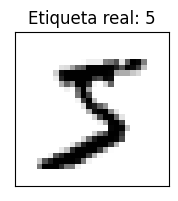

In [6]:
# prueba que está todo ok
img, label = train_features[0].squeeze(), train_labels[0]
fig = plt.figure(1,figsize=(2, 2))
plt.imshow(img, cmap="binary")
plt.title(f"Etiqueta real: {label}")
plt.xticks([]); plt.yticks([])
plt.show()

#### 3. Define la red neuronal (MLP)

In [7]:
# arquitectura de la red (MLP dos capas)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.sigmo1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmo1(out)
        out = self.l2(out)
        out = self.softmax(out)
        return out

# inicializa la red
model = MLP(input_size = 28*28, hidden_size=100, num_classes=10)

# Muestra la red
print("Estructura de la red:")
for param_tensor in model.state_dict():
    print(f'{param_tensor} \t {model.state_dict()[param_tensor].size()}')

# resumen nº de params en cada capa
print(summary(model))

Estructura de la red:
l1.weight 	 torch.Size([100, 784])
l1.bias 	 torch.Size([100])
l2.weight 	 torch.Size([10, 100])
l2.bias 	 torch.Size([10])
Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            78,500
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            1,010
├─Softmax: 1-4                           --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0


#### 4. Ajusta la red iterando el nº de épocas indicado

In [8]:
# función de pérdida
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizador = torch.optim.Adam(model.parameters(), lr = learning_rate)

# nº de épocas
n_epochs = 3

Ajusta el modelo con 3 épocas:
Época: 1/3  - Step: 200/600 :: loss = 1.8144198656082153
Época: 1/3  - Step: 400/600 :: loss = 1.7475911378860474
Época: 1/3  - Step: 600/600 :: loss = 1.6379446983337402
Época: 2/3  - Step: 200/600 :: loss = 1.6487846374511719
Época: 2/3  - Step: 400/600 :: loss = 1.5833320617675781
Época: 2/3  - Step: 600/600 :: loss = 1.5314698219299316
Época: 3/3  - Step: 200/600 :: loss = 1.5667333602905273
Época: 3/3  - Step: 400/600 :: loss = 1.5507818460464478
Época: 3/3  - Step: 600/600 :: loss = 1.5067009925842285
Modelo ajustado en 3 épocas.


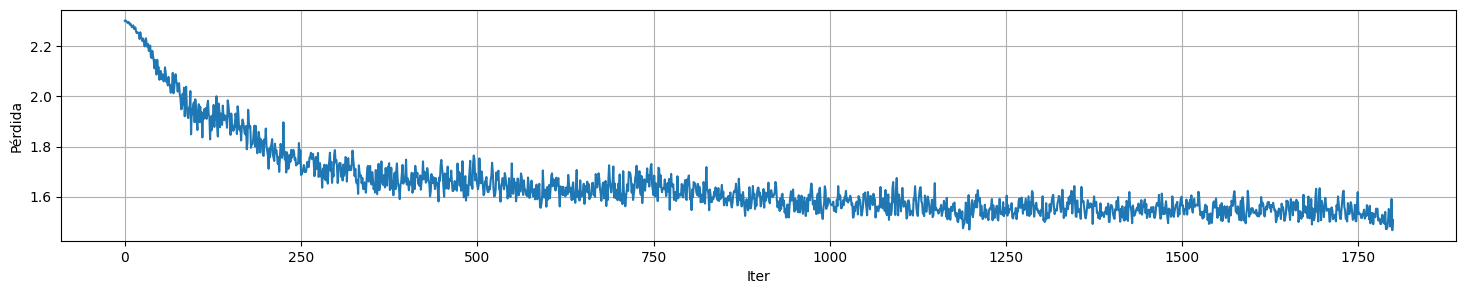

In [9]:
# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)
k=0
print(f'Ajusta el modelo con {n_epochs} épocas:')
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.reshape(-1, 28*28).to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = model(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backward
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if (i+1) % 200 == 0:
            print(f'Época: {epoch+1}/{n_epochs} '
                  f' - Step: {i+1}/{n_total_steps} :: loss = {loss.item()}')


print(f'Modelo ajustado en {n_epochs} épocas.')
fig = plt.figure(1,figsize=(18, 3))
plt.plot(tr_eval_loss)
plt.xlabel('Iter')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

#### 5. Calcula % aciertos y matrices de confusión en TR y TS

TR ----------
   Correctas (TR):56247 Incorrectas(TR):3753
   Aciertos (TR): 93.745 %
TS ----------
   Correctas (TS):9347 Incorrectas(TS):653
   Aciertos (TS): 93.47 %


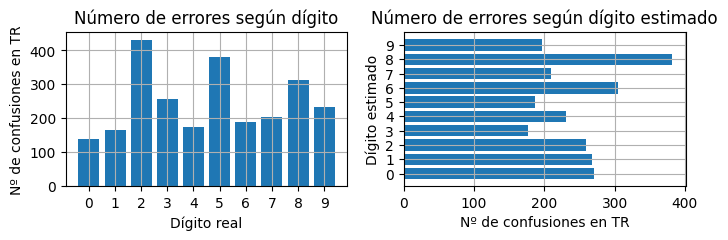

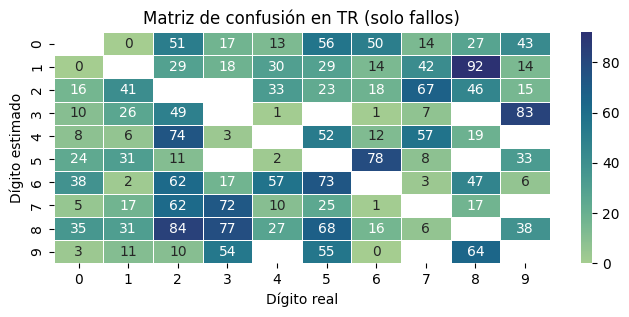

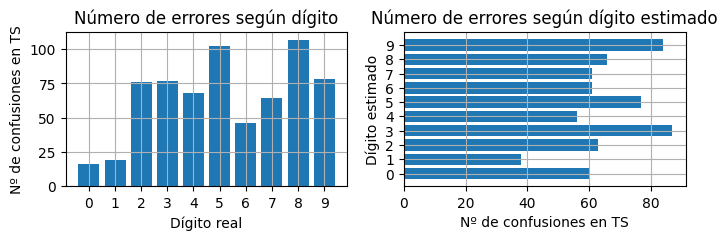

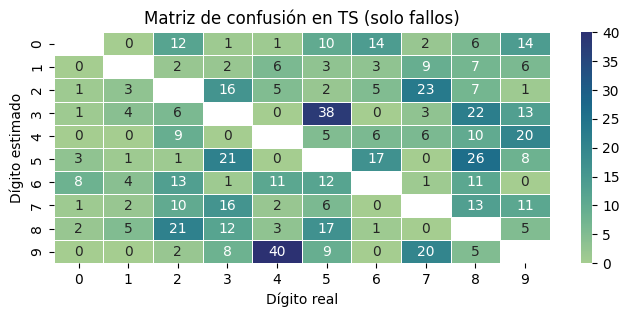

In [10]:
util_mlp_cnn_ESU23.calcula_aciertos_modelo(train_loader, model, 'TR')
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, model, 'TS')

util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(train_loader, model, 'TR', 10)
util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, model, 'TS', 10)

#### 6. Análisis imágenes mal clasificadas

In [11]:
# util_mlp_cnn_ESU23.muestra_ejemplos_fallos(train_loader, model, 'TR', digito=3)

Muestra 100 ejemplos de imágenes mal clasificadas en TS:


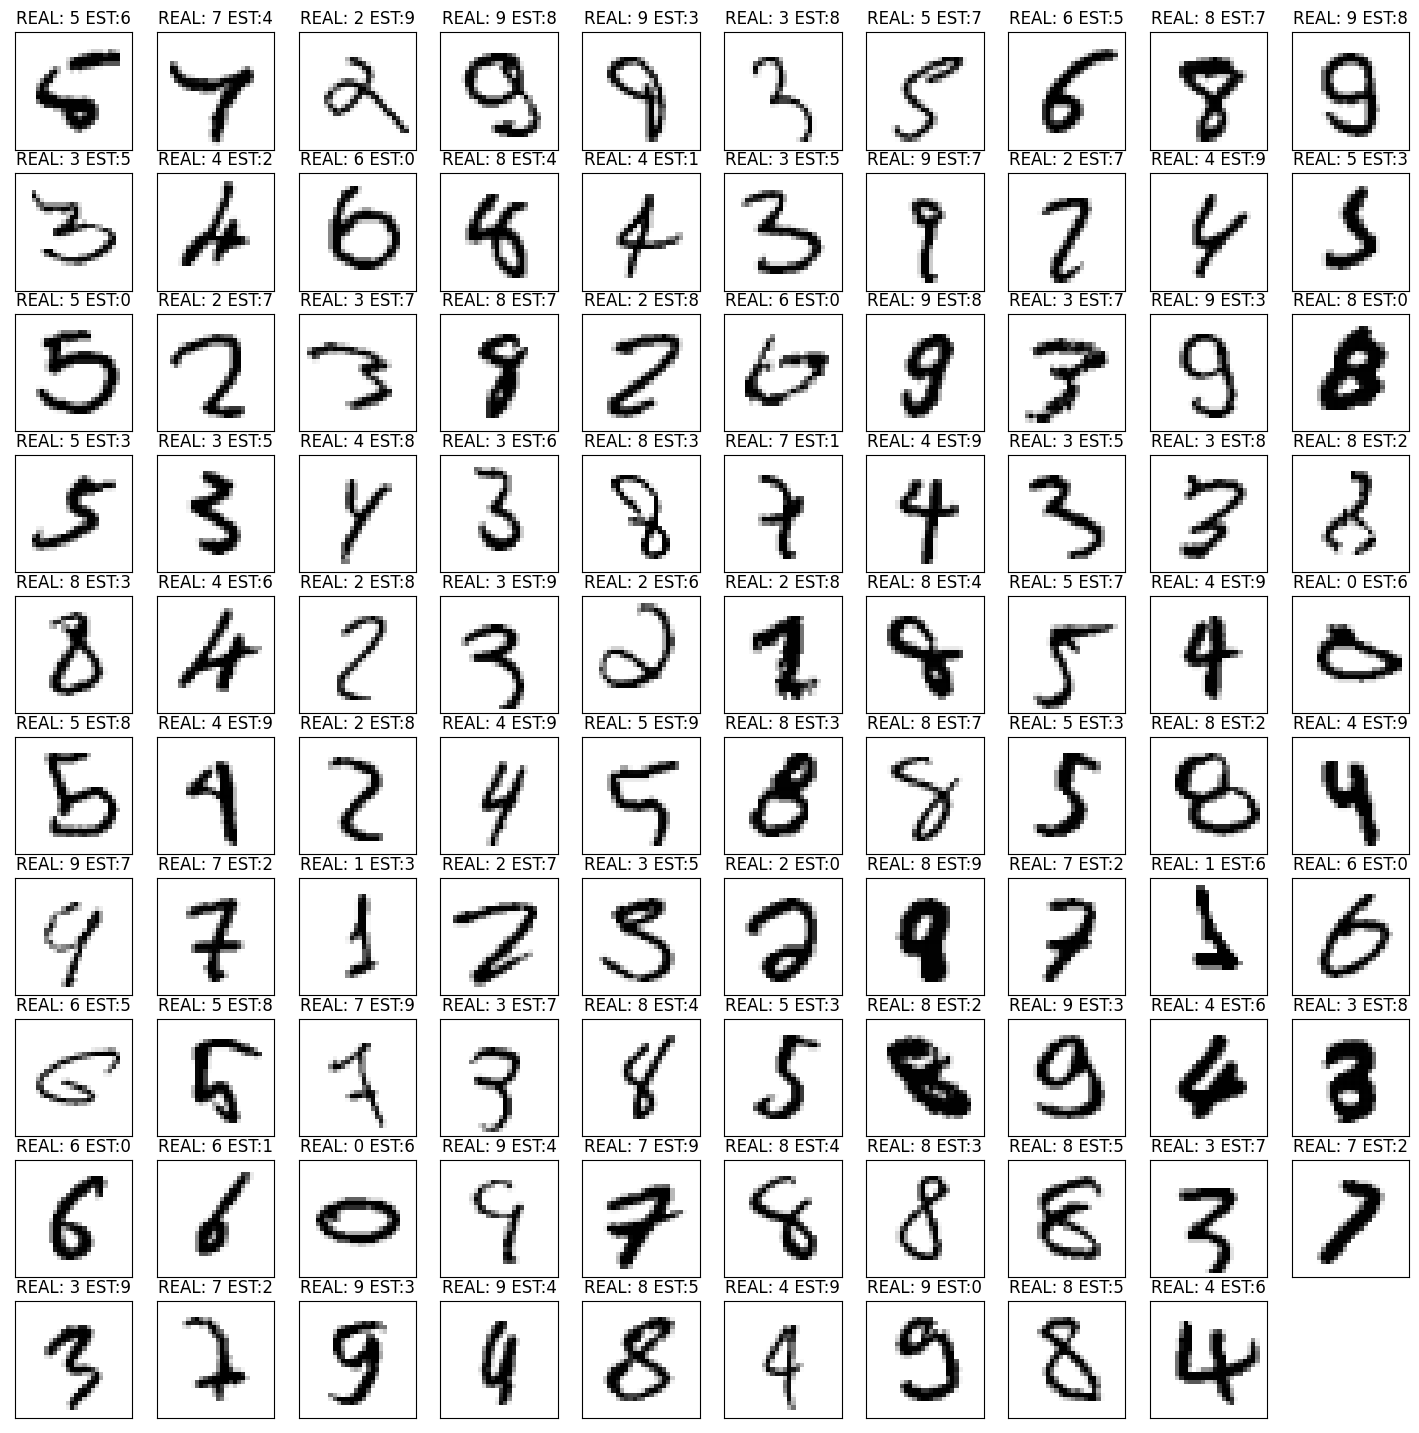

Muestra 20 ejemplos de imágenes mal clasificadas en TS del dígito 5:


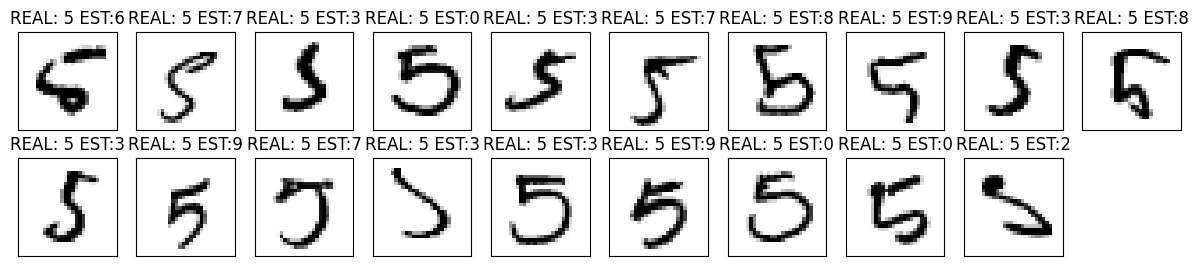

In [12]:
util_mlp_cnn_ESU23.muestra_ejemplos_fallos(test_loader, model, 'TS', digito=5)

#### 7. Guarda el modelo para su uso posterior

In [13]:
GUARDAR = False
if GUARDAR:
   print(f'Ruta actual: {os.getcwd()}')
   ruta_mod = os.path.join(os.getcwd(), "modelos")
   if not os.path.exists(ruta_mod):
      os.makedirs(ruta_mod)
      print(f'Se crea {ruta_mod}')

   fecha_creacion = '2023_11_16'
   nom_fi_mod = f'mlp_{n_epochs}_epocas_ajustado_MNIST_{fecha_creacion}.pth'
   ruta_fi_mod = os.path.join(ruta_mod, nom_fi_mod)
   torch.save(model.state_dict(), ruta_fi_mod)
   print(f'modelo {nom_fi_mod} guardado.')
else:
   print('No se guarda.')

No se guarda.
